Assignment 4\
Khalid Saifullah\
ID: A20423546\
\
Solution to question 2(e)

In [1]:
# Loading all the libraries
import keras
import pickle
import random
import numpy as np
import matplotlib.pyplot as plt

from keras import optimizers
from keras.optimizers import SGD
from keras import Input, layers, Model
from keras.utils import to_categorical
from keras.models import Sequential, load_model
from sklearn.model_selection import train_test_split
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, BatchNormalization, Activation, Dropout

#random.seed(0)

In [2]:
# This Unpickle function has been obtained from Cifar-10 website
def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

# Preparing the training and testing dataset
def prepare_data():
    # Loading the training dataset
    batch_labels = []
    batch_images = []
    for n in range(1, 6):
        batch_dict = unpickle(f"cifar-10-batches-py/data_batch_{n}")
        # Adding the labels to the list of batch labels
        batch_labels.append(batch_dict[b'labels'])
        # Loading the images, and resizing them to 10000x3x32x32
        data = batch_dict[b'data'].reshape((10000,3,32,32))
        # Modifying the axis to make it 10000x32x32x3
        data = np.moveaxis(data, 1, -1)
        batch_images.append(data)
    train_labels = np.concatenate(batch_labels, axis=0)
    train_images = np.concatenate(batch_images, axis=0)
    # Loading the testing dataset
    test_dict = unpickle(f"cifar-10-batches-py/test_batch")
    test_labels = np.array(test_dict[b'labels'])
    test_images = test_dict[b'data'].reshape((10000,3,32,32))
    test_images = np.moveaxis(test_images, 1, -1)
    # Normalizing the images
    train_images = train_images.astype('float32') / 255.0
    test_images = test_images.astype('float32') / 255.0
    # 1-hot encoding the labels
    train_labels = to_categorical(train_labels)
    test_labels = to_categorical(test_labels)
    return train_images, train_labels, test_images, test_labels

# defining the CNN model
def define_model():
    input_tensor = Input(shape=(32,32,3))
    a1 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')(input_tensor)
    a1 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')(a1)
    amax = MaxPooling2D((2, 2))(a1)

    b1 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')(amax)
    b1 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')(b1)
    bmax = MaxPooling2D((2, 2))(b1)

    #residual blocks
    res = layers.Conv2D(64, (3,3), activation='relu', padding='same')(bmax)
    res = layers.Conv2D(64, (3,3), activation='relu', padding='same')(res)
    res = layers.Conv2D(64, (3,3), activation='relu', padding='same')(res)
    res = layers.add([res, bmax])

    flat= Flatten()(res)
    flat = Dense(128, activation='relu', kernel_initializer='he_uniform')(flat)
    output_tensor = Dense(10, activation='softmax')(flat)
    model = Model(inputs = input_tensor, outputs = output_tensor)
    model.summary()
   
    # compiling the model
    opt = SGD(lr=0.001, momentum=0.9)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# plotting the learning curves
def learning_curves(history):
   # plotting loss
    print(history.history.keys())
    epochs = range(1, len(history.history['accuracy'])+1)
    plt.figure(figsize=(10,12), facecolor='w')
    plt.subplot(211)
    plt.title('Cross Entropy Loss')
    plt.plot(epochs, history.history['loss'], 'bo', label='Training loss')
    plt.plot(epochs, history.history['val_loss'], 'r', label='Validation loss')
    plt.legend()
    # plotting accuracy
    plt.subplot(212)
    plt.title('Classification Accuracy')
    plt.plot(epochs, history.history['accuracy'], 'bo', label='Training accuracy')
    plt.plot(epochs, history.history['val_accuracy'], 'r', label='Validation accuracy')
    plt.legend()
    plt.show()
    plt.close()

# defining the run model
def run_model():
    # defining the model
    model = define_model()
    # loading the prepared dataset
    trainX, trainY, testX, testY = prepare_data()
    # Splitting into training and validation dataset
    trainX, valX, trainY, valY = train_test_split(trainX, trainY, test_size=0.3, shuffle=True, random_state=0, stratify=trainY)
    # fitting the model
    history = model.fit(trainX, trainY, epochs=40, batch_size=128, validation_data=(testX, testY))
    # Showing the learning curves
    learning_curves(history)
    # saving the model
    model.save('cifar10_residualblock.h5')

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 32, 32)   896         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 32, 32)   9248        conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 16, 16, 32)   0           conv2d_1[0][0]                   
______________________________________________________________________________________________

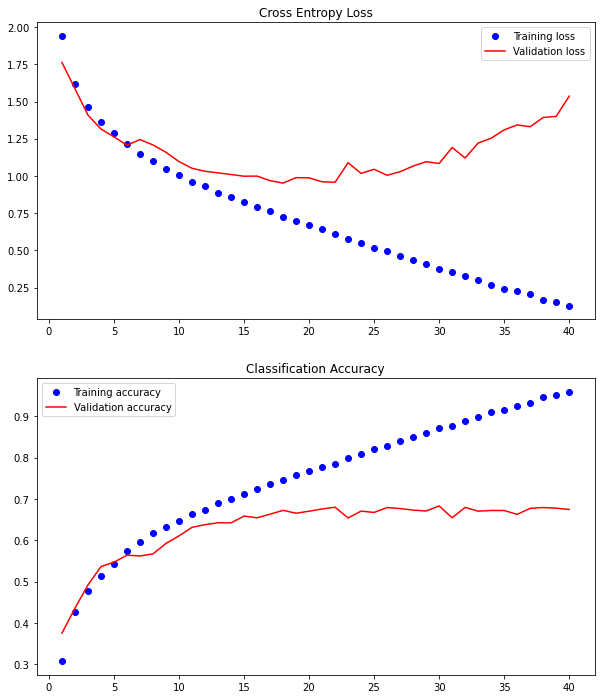

In [3]:
# Running the run_model
run_model()

In [4]:
# Evaluating the final model on the testing dataset
trainX, trainY, testX, testY = prepare_data()
final_model = load_model('cifar10_residualblock.h5')
_, acc = final_model.evaluate(testX, testY, verbose=0)
print('>> Accuracy = %.3f' % (acc * 100.0))

>> Accuracy = 67.480


(32, 32, 3)

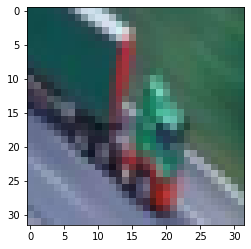

In [5]:
trainX, trainY, testX, testY = prepare_data()
plt.imshow(trainX[50])
trainX[50].shape